# Computer Vision - P5

### **Carefully read the file `README.md` as well as the following instructions before start coding.**

## Delivery

Up to **1 point out of 10** will be penalized if the following requirements are not fulfilled:

- Implemented code should be commented.

- The questions introduced in the exercises must be answered.

- Add title to the figures to explain what is displayed.

- Comments need to be in **engrish**.

- The deliverable must be a file named **P5_Student1_Student2.zip** that includes:
    - The notebook P5_Student1_Student2.ipynb completed with the solutions to the exercises and their corresponding comments.
    - All the images used in this notebook.

**Deadline (Campus Virtual): December 11th, 23:00 h** 

==============================================================================================
## Practicum 5: Image search using textures


==============================================================================================



The exercises of this notebook will show how we can perform image similarity search using:

- Gaussian filters
- Descriptors based on texture and color

#### Problem we want to solve
- Given a query image **$x$** and a set of images **$X$** we would like to retreive the most similar to **$x$** images from  **$X$**.



 The function should return a feature vector obtained by averaging each filter response on the image.  

**Hint**: Note that since at this moment we are focusing on the texture, we will not use the color of the images.

## Looking at the images

In [1]:
%matplotlib inline

import time
import scipy
import numpy as np
import skimage
from skimage import filters, io
import os

import matplotlib.pyplot as plt

In [2]:
path = "./images/texturesimages/buildings/"
building_images = [skimage.io.imread(path + f) for f in os.listdir(path)]

path = "./images/texturesimages/forest/"
forest_images = [skimage.io.imread(path + f) for f in os.listdir(path)]

path = "./images/texturesimages/sunset/"
sunset_images = [skimage.io.imread(path + f) for f in os.listdir(path)]

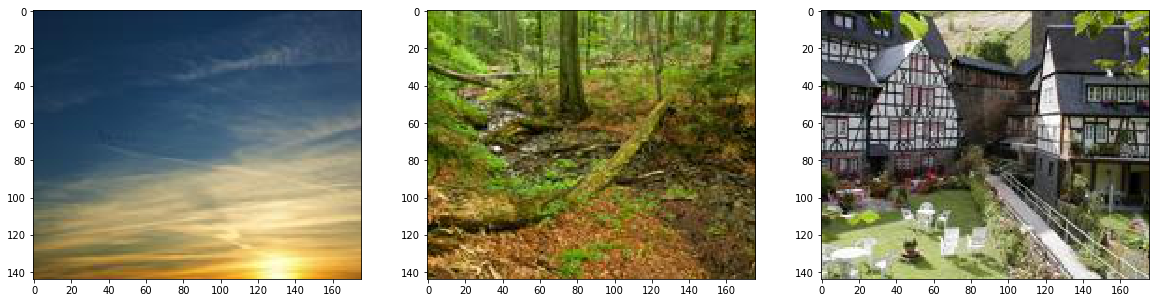

In [3]:
fig, ax= plt.subplots(ncols=3, nrows=1, figsize=(20,30))

ax[0].imshow(sunset_images[0])
ax[1].imshow(forest_images[0])
ax[2].imshow(building_images[0])
plt.show()

In [4]:
len(sunset_images), len(forest_images), len(sunset_images)

(30, 30, 30)

# Filter banks

We can apply a collection of multiple filters that we call a filter bank. Note that if we apply $D$ filters our feature vectors will be $D$ dimensional.

The following image shows a filter bank. In the filter bank we typically want filters to capture a combination of scales, orientations of different types of patterns. This particular filter bank is The Leung-Malik (LM) Filter Bank.

<img src="./images_notebook/filter_bank.png">


## Leung-Malik (LM) Filter Bank

In [5]:
import LM_filters

LM filters imported, the shape of the filter bank is:  (49, 49, 48)


In [6]:
filter_bank = LM_filters.makeLMfilters()
filter_bank.shape

(49, 49, 48)

### Plotting all filters

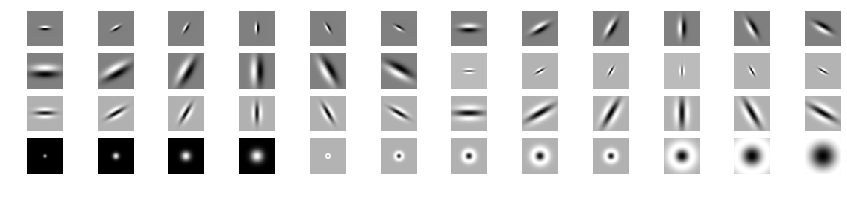

In [7]:
n_filters = filter_bank.shape[-1]

fig, ax = plt.subplots(ncols=12, nrows=4, figsize=(15,3))

k = 0
for i in range(4):
    for j in range(12):
        ax[i,j].imshow(filter_bank[:,:,k], cmap = 'gray')
        ax[i,j].axis("off")
        k = k + 1


## Exercise 5.1 Plot the convolved image by some of the filters


Make a function `visualize_features(im,  filter_bank, n_filters=5)` that recieves the `filter_bank`, an image `im` and an integer `n_filters`. 

The function  must make a plot of two rows containing in the first row, in position $k$, the image convolved by filter $k$. In the second row, in position $k$, the image of the k'th filter. The result for `n_filter=5` should look like 


<img src="./images/filters.png">


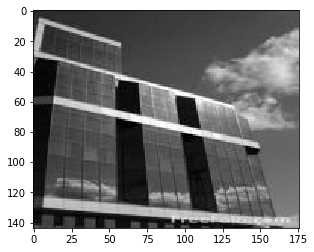

In [8]:
im = building_images[5]
im = skimage.color.rgb2gray(im)
plt.imshow(im, cmap="gray")

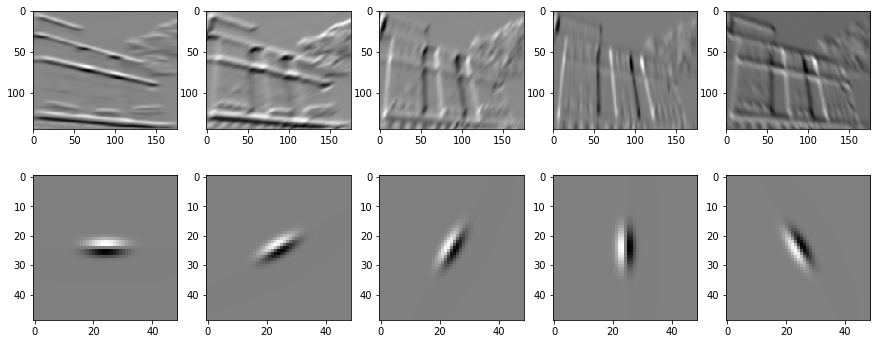

In [179]:
from scipy import ndimage

def visualize_features(im,  filter_bank, n_filters=5):
    
    fig, ax = plt.subplots(ncols=n_filters, nrows=2, figsize=(15,6))
    plt.gray()
    
    # Iterate over the first n_filters filters in bank
    for i in range(n_filters):
        
        f = filter_bank[:,:,i]
        
        # Convolve image using current filter
        result = np.zeros(im.shape)
        ndimage.convolve(im, f, output = result)

        # Display result
        ax[0, i].imshow(result)
        ax[1, i].imshow(f)
        
visualize_features(im, filter_bank, 5)


## Exercise 5.2 Constructing a feature vector for a given image


Given $D$ filters from the filter bank and a single image `image`, make a function `features_from_filter_bank(image, filter_bank, n_filters)` that returns a feature vector of shape `n_filters`. The returned vector must contain at position $k$ the mean of the absolute value of the convolved image by filter $k$.

$$
\text{feat}(x) = \left( \text{mean}( |r_1|), \dots,\text{mean}(|r_D|) \right)
$$



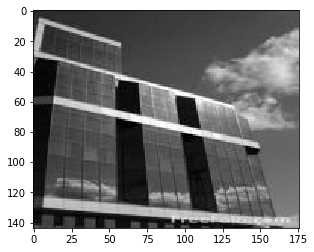

[2.27477963e-02 1.44737375e-02 1.05258970e-02 1.06517191e-02
 1.31402307e-02 2.07901149e-02 1.37073541e-02 7.67197385e-03
 7.06356192e-03 7.49856090e-03 7.26270043e-03 1.12680961e-02
 8.67426194e-03 5.43329721e-03 5.29131741e-03 5.94648710e-03
 5.14295927e-03 6.94340634e-03 1.20769901e-02 4.70907784e-03
 3.46303608e-03 5.52372698e-03 4.63493491e-03 9.20235764e-03
 4.53586835e-03 1.43878491e-03 1.32222813e-03 2.06080017e-03
 1.52170511e-03 3.07114348e-03 2.06506282e-03 7.38435218e-04
 7.60341428e-04 1.11512229e-03 8.68125065e-04 1.43070449e-03
 1.26823655e+00 2.53647309e+00 3.80470958e+00 5.07279940e+00
 6.34118273e-01 3.17059136e-01 2.11372650e-01 1.58434294e-01
 2.11372650e-01 9.73868529e-02 3.09335926e-02 3.00803290e-03]


In [180]:
import math

plt.imshow(im)
plt.show()

def features_from_filter_bank(image, filter_bank, n_filters):
    
    image = skimage.color.rgb2gray(image)

    im_conv = np.zeros(image.shape)
    features_for_im = np.zeros(n_filters)
    
    # Iterate over the first n_filters filters in bank
    for i in range(n_filters):
        
        f = filter_bank[:,:,i]
        
        # Convolve image using current filter
        ndimage.convolve(image, f, output = im_conv)
        
        # Store mean of absolute value of result matrix
        # in features vector
        features_for_im[i] = np.mean(abs(im_conv))
  
    return features_for_im

features_for_im = features_from_filter_bank(im, filter_bank, n_filters)
print (features_for_im)

## Exercise 5.3 Constructing the matrix of the feature vectors for all images

Implement a function `get_class_Features(all_images, filter_bank)` that applies `features_from_filter_bank` to get a feature vector for each of the images in the union of the three datasets (forest, buildings, sunset). It must return a matrix containing at row $k$ feature vector for the input image $k$.


Wall time: 7min 49s

In [11]:
all_images = building_images + forest_images + sunset_images

In [12]:
%%time
from skimage import color

def get_class_features(all_images,  filter_bank):

    n_images = len(all_images)
    n_filters = filter_bank.shape[-1]
    all_feature_vectors = np.zeros((n_images, filter_bank.shape[-1]))
    
    # Iterate over all images and obtain their feature vector
    for i in range(n_images):
        
        # Store feature vector at i position in all_feature_vectors
        all_feature_vectors[i] = features_from_filter_bank(all_images[i], filter_bank, n_filters)

    return all_feature_vectors

all_feature_vectors = get_class_features(all_images,  filter_bank)
print(len(all_feature_vectors))

90
CPU times: user 9min 52s, sys: 16 s, total: 10min 8s
Wall time: 10min 20s


## Exercise 5.4 Visualizing the features of an image

Define a function `visualize_features` that given a feature index and an array containing all feature vectors, plots its values for the three datasets using different colors for each dataset (in total plots should contain 3 colors).


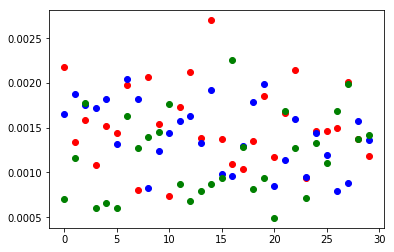

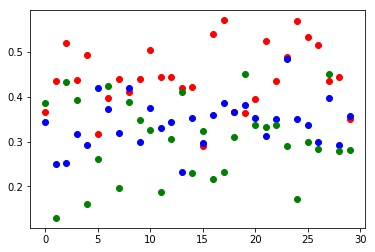

In [40]:
def visualize_features(k, all_feature_vectors):
    
    feature_vals = []
    segment_size = math.floor(len(all_feature_vectors) / 3)
    
    # Generate x-axis range from 0 to a third of the size of all_feature_vectors
    x = np.arange(segment_size)
    
    # From each feature vector, retrieve feature at index k 
    for feature_vector in all_feature_vectors:
        feature_vals.append(feature_vector[k])
    
    # Plot result
    plt.plot(x, feature_vals[:segment_size], 'ro', 
             x, feature_vals[segment_size:segment_size * 2], 'bo', 
             x, feature_vals[segment_size * 2:segment_size * 3], 'go')
        
    plt.show()
    
visualize_features(25, all_feature_vectors)    
visualize_features(41, all_feature_vectors)





#### Similarity search

Let us assume $f(x) \in \mathbb{R}^D$ represents a set of features for $x$. Given a query image $x$ and another image $x^m$ from the database, we can compute the distance between images as
$$
\text{distance}\left( f(x) , \, f(x^m) \right) = \| \text{feat}(x)  - \text{feat}(x^m)  \|_2 =  \sqrt{ \sum_{d=1}^\text{D} \left( f(x)_d - f(x^m)_d  \right)^2 }
$$

then we can find the closest image $x^{m^*}$ from the database to $x$ as $m^* =  \text{argmin}_{m} \{ \| \text{feat}(x)  - \text{feat}(x^m)  \|_2 \}$


## Exercise 5.5 Retrieving the most similar and different images



Implement a function `retrieve_k_images_from_X(query, X, k)` where `query` is an image,  `X` ins the array containing the features from all the images and  `k` is an integer. The function should retrieve the `k` most similar and distant images (according to the l2 norm) and the distances from the closest and the furthest images to the query image. You can include the query image since it is in `X`.

- Make a plot with the first column beeing the query image and the other k columns the closest images in the feature space.

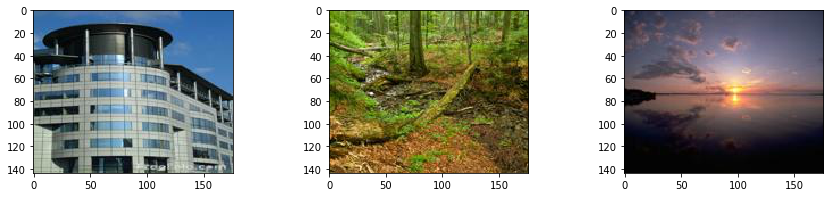

In [122]:
X = np.array(all_feature_vectors)
ind_1 = 6
ind_2 = 30
ind_3 = 65

query_1 = X[ind_1,:]
query_2 = X[ind_2,:]
query_3 = X[ind_3,:]


# Display the query images
fig, ax = plt.subplots(ncols=3, nrows=1, figsize=(15,3))
ax[0].imshow(all_images[ind_1]) 
ax[1].imshow(all_images[ind_2])
ax[2].imshow(all_images[ind_3])

In [66]:
def feature_distance(im1, im2):
    """
    Compute euclidean distance between feature vector for input images
    """
    return np.linalg.norm(im1 - im2)
    
def retrieve_k_images_from_X(query, X, k):
    
    distances = []

    # For each feature vector, compute distance from query and store in array
    for i, x in enumerate(X):
        distances.append((i, feature_distance(query, x)))
    
    # Sort computed distance and retrieve k lowest values
    sorted_distances = sorted(distances, key = lambda x: x[1])

    # Retrieve closest images
    closest_to_query = sorted_distances[:k]
    closest_images = [all_images[i[0]] for i in closest_to_query]

    # Retrieve furthest images
    furthest_from_query = sorted_distances[len(sorted_distances) - k:]
    furthest_images = [all_images[i[0]] for i in furthest_from_query]

    return closest_to_query, furthest_from_query

In [ ]:
k = 10
similar_images = retrieve_k_images_from_X(query_1, X, k)

fig, ax = plt.subplots(ncols=k, nrows=1, figsize=(10,2))

for i in range(k):
    ax[i].imshow(all_images[similar_images[i][0]]) 

plt.show()


## Exercise 5.6 Retrieving the most similar image based on the information about color

Based on exercises 5.3 and 5.4:
1)  Implement a function `get_rgb_Features(all_images)` that obtains the RGB information by applying `exposure.histogram(image,nbins=32)` to get a feature vector for each of the images in the union of the three datasets (forest, buildings, sunset). It must return a matrix containing at row $k$ feature vector for the input image $k$.

2)  Use the same function `retrieve_k_images_from_X(query, X, k)` where `query` is an image, `X` ins the array containing the features from all the images and  `k` is an integer. The function should retrieve the `k` most similar and distant images (according to the l2 norm) and the distances from the closest and the furthest images to the query image. You can include the query image since it is in `X`.

- And again, make a plot with the first column beeing the query image and the other k columns the closest images in the feature space.

In [69]:
from skimage import exposure

def get_rgb_features(all_images):
    """
    Get color histogram of each image as feature
    """
    
    feature_matrix = []
    
    # Iterate over all images
    for img in all_images:
        
        # Convert image to float
        img = skimage.img_as_float(img)
        
        # Compute histogram for each channel in image
        r_histogram = exposure.histogram(img[...,0], nbins = 32)[0]
        g_histogram = exposure.histogram(img[...,1], nbins = 32)[0]
        b_histogram = exposure.histogram(img[...,2], nbins = 32)[0]
        
        # Generate matrix where columns represent the histogram for each color.
        # Add matrix to feature_matrix.
        feature_matrix.append(np.matrix([r_histogram, g_histogram, b_histogram]))
    
    return feature_matrix

rgb_features = get_rgb_features(all_images)
rgb_query = rgb_features[0]

retrieve_k_images_from_X(rgb_query, rgb_features, 10)

([(0, 0.0),
  (38, 2489.8200738205965),
  (44, 2565.3732671874477),
  (54, 3213.363035823995),
  (46, 3784.41673180954),
  (59, 3894.1720557777103),
  (45, 3978.6573112043716),
  (52, 4130.086197647695),
  (19, 4463.410803410325),
  (18, 4591.32159622913)],
 [(62, 11294.883443400378),
  (16, 11782.014768281357),
  (78, 12619.23817034927),
  (71, 12846.020551127885),
  (61, 13077.076814028433),
  (72, 14167.66000439028),
  (80, 15368.947068683658),
  (67, 15972.514517132235),
  (84, 17747.59431585025),
  (64, 24973.896692346592)])

## Exercise 5.7 Compute the accuracy of the algorithm: given a query image. 

Make a function 

```
accuracy(X, class_labels, k=5, query=x, class_query=y)
```

That takes as input a the dataset `X`, the `class_labels` for the images, the number of images to retrieve `k`, a query image `x` and the class of the query image `y`. Returns as output the number of retrieved images that belong to class `y` divided by the total of images retrieved `k` (this is the accuracy).

**Hint**: be careful to exclude the query image from the retrieved images.



- Compute the accuracy with k=4 with the previous images. Does the accuracy match the images retrieved from the previous exercise?



In [73]:
class_labels = np.concatenate((np.zeros(30), np.ones(30),  2*np.ones(30))).reshape(90,1)

In [196]:
def accuracy(X, class_labels, k, query, class_query):
    
    closest, furthest = retrieve_k_images_from_X(query, X, k + 1)
    success = 0
    failure = 0
    
    # Iterate over result, skipping first image (query itself)
    for r in closest[1:]:
        img_id = r[0]
        
        # Increase number of successful or failed matches accordingly
        if class_labels[img_id] == class_query:
            success += 1
            
        else:
            failure += 1
            
    print ("Success:", success, "\nFailure:", failure)
    return success / k

accuracy(X, class_labels, 10, query_3, 2)

Success: 6 
Failure: 4


0.6

- Compute the accuracy for both cases, when X is obtained by (A) applying the bank of filters or (B) the color information.



- Compare the results obtained. Which descriptors give better performance? Can you explain why?

## Exercise 5.8 Image retrieval based on texture and color. 

Make a function ` lm_features_rgb(image, filter_bank)`  that returns the features from the filter bank concatenated per color. If the previous feature vectors had 49 components now they will have 49*3 components. 


In [198]:
def lm_features_rgb(image, filter_bank):
    
    # Convert image to float
    image = skimage.img_as_float(image)
    
    n_filters = len(filter_bank) - 1
    im_conv = np.array(image[:,:,0])
    features_for_im = np.zeros(3*n_filters)
    
    # Iterate over each color channel in image
    for c in range(image.shape[2]):
        channel = image[:,:,c]
        
        # Iterate over n_filters in filter bank
        for i in range(n_filters):
            
            f = filter_bank[:,:,i]

            # Convolve image using current filter
            ndimage.convolve(channel, f, output = im_conv)

            # Store mean of absolute value of result matrix
            # in features vector
            features_for_im[n_filters * c + i] = np.mean(abs(im_conv))
            
    return features_for_im
    
lm_features_rgb(all_images[0], filter_bank)

array([2.00431630e-02, 1.60397584e-02, 1.54784381e-02, 1.71810348e-02,
       1.69160519e-02, 1.84508582e-02, 1.06622722e-02, 9.37953031e-03,
       8.45267497e-03, 9.09039590e-03, 9.77421678e-03, 9.97811126e-03,
       7.70482539e-03, 7.08984023e-03, 5.60113181e-03, 5.95660141e-03,
       6.87609677e-03, 7.15345554e-03, 1.20427525e-02, 7.73731304e-03,
       7.63666487e-03, 1.02409976e-02, 8.43305452e-03, 9.60267791e-03,
       2.86872196e-03, 2.19296917e-03, 2.16971184e-03, 2.64113614e-03,
       2.53739037e-03, 2.41546591e-03, 1.29738722e-03, 1.11398891e-03,
       1.00881204e-03, 1.23944383e-03, 1.27334046e-03, 1.08205078e-03,
       1.47769816e+00, 2.95539632e+00, 4.43309441e+00, 5.91062162e+00,
       7.38849079e-01, 3.69424540e-01, 2.46282902e-01, 1.84601260e-01,
       2.46282902e-01, 1.13471240e-01, 3.60425766e-02, 3.14384057e-03,
       2.03118215e-02, 1.63115086e-02, 1.56202291e-02, 1.71215768e-02,
       1.69556989e-02, 1.85898793e-02, 1.10751125e-02, 9.72269295e-03,
      

## Exercise 5.9 Apply the function to all the images in the dataset

Using ` lm_features_rgb(image, filter_bank)` build the features of all the datapoints in and save them in `X_lm_rgb`.
You can parallelize the feature building process using `joblib.Parallel`. This will make the computation much faster if you have a processor with more than two threads.

In [ ]:
def apply_features_rgb(images, filter_bank):
    """
    Apply lm_features_rgb to all given images
    """
    
    result = []
    
    # Apply function to all images and store in result array
    for img in images:
        result.append(lm_features_rgb(img, filter_bank))
        
    return result

X_lm_rgb = apply_features_rgb(all_images, filter_bank)

## 5.10 Compute the accuracy of the method using lm rgb features

Use the function implemented in 5.6 to compute the accuracy of the retrieved images using the features that contain color information. Make a plot of the 4 closest images to the query images in the `lm_rgb` space.

- Is the accuracy higher?

In [222]:
# compute (X_lm_rgb) and cast it as array
X_lm_rgb = np.array(X_lm_rgb)

accuracy(X_lm_rgb, class_labels, 10, x_lm_rgb[0], 0)

Success: 1 
Failure: 0


0.1